# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from torch.nn import Softmax
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS, RTHETA_COLS, XY_RTHETA_COLS, XY_VXVY_RTHETA_COLS 
from isaac.evaluation import predict_with_a_group_of_saved_models
from isaac.statistical_tests import z_test

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
device = get_cuda_device_if_available()
print(device)

cpu


In [3]:
normalise_data = True
scaler_path = "scalers/passive_rtheta_scaler.sk"
network_dims = (len(RTHETA_COLS), 25, 3, 0.5)
dataset_path = "../new_exp_data/exp7_passive_rtheta.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
seq_end = 2700
step_size = 3

def get_question_predictions_for_group_of_models(question_type):    
    models = sorted(glob.glob("models/rtheta/best_mass_model_seed_*.pt"))

    group_predictions = []
    
    predictions = predict_with_a_group_of_saved_models(tqdm(models), network_dims, dataset_path, 
                                                       training_columns=RTHETA_COLS, 
                                                       class_columns=class_columns, step_size=step_size, 
                                                       seq_end=seq_end, scaler_path=scaler_path,
                                                       arch=MultiBranchModel, multiclass=multiclass, trials=None)

    predictions = torch.stack(predictions)
    
    print(predictions.shape)
    if question_type == "mass":
        predictions = predictions[:, :, :, 0]
    else:
        predictions = predictions[:, :, :, 1]

    return predictions

def get_participant_accuracy(passive_responses, answer_column, question_type_answer):
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

# T-test for MASS questions

## Load model's predictions

In [4]:
print("MASS")
question_type = "mass"
group_mass_prediction = get_question_predictions_for_group_of_models(question_type)
    
print("\nFORCE")
question_type = "force"
group_force_prediction = get_question_predictions_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
  0%|          | 0/25 [00:00<?, ?it/s]/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


torch.Size([25, 36, 3, 2])

FORCE


100%|██████████| 25/25 [00:23<00:00,  1.06it/s]

torch.Size([25, 36, 3, 2])


In [5]:
s = Softmax(dim=2)
group_force_prediction = s(group_force_prediction)
group_mass_prediction = s(group_mass_prediction)

In [6]:
mean_force_prediction = group_force_prediction.mean(dim=0)
mean_mass_prediction = group_mass_prediction.mean(dim=0)

In [7]:
all_predictions = torch.cat((mean_mass_prediction, mean_force_prediction), dim=1).numpy()

In [8]:
model_predictions_df = pd.DataFrame(data=all_predictions, columns=list(MASS_CLASS_COLS) + list(FORCE_CLASS_COLS))

In [9]:
import json

In [10]:
condition_world_variant = []
world_id = []

for condition_id in range(1, 5):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [11]:
model_predictions_df["condition_world_variant"] = condition_world_variant
model_predictions_df["world_id"] = world_id

In [12]:
model_predictions_df = model_predictions_df.reset_index()

## Load human results

In [13]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWa

In [14]:
rdata_path = "../new_exp_data/e7_passive_io_rtheta.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


# Percentage of participants that chose each answer

In [15]:
passive_responses = []

for name, df in responses.groupby(["cond_worldvar", "world_id", "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                   "true_mass", "true_rel", 
                                   "post_att.rtheta", "post_none.rtheta", "post_rep.rtheta", 
                                   "post_same.rtheta", "post_A.rtheta", "post_B.rtheta"]):
    response = [name[0], name[1], name[2], name[3], name[4], name[5],
                name[6], name[7], name[8], name[9], name[10], name[11]]
    
    value_counts = df.resp_rel.value_counts()
    for col in FORCE_CLASS_COLS:
        response.append(value_counts[col])
    
    value_counts = df.resp_mass.value_counts()
    for col in MASS_CLASS_COLS:
        response.append(value_counts[col])
        
    avg_conf_mass = df.conf_mass.mean()
    response.append(avg_conf_mass)
    avg_conf_rel = df.conf_rel.mean()
    response.append(avg_conf_rel)
        
    passive_responses.append(response)

In [16]:
passive_responses = pd.DataFrame(data=passive_responses, 
                                 columns=["cond_worldvar", "world_id", 
                                          "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                          "true_mass", "true_rel", "attract_io", "none_io", "repel_io",
                                          "same_io", "A_io", "B_io"] + list(FORCE_CLASS_COLS) + list(MASS_CLASS_COLS) + 
                                         ["conf_mass", "conf_rel"])

In [17]:
passive_responses["cond_worldvar"] = passive_responses["cond_worldvar"].astype("int64")
passive_responses["world_id"] = passive_responses["world_id"].astype("int64")

In [18]:
passive_responses = passive_responses.merge(model_predictions_df, left_on=["cond_worldvar", "world_id"], 
                                            right_on=["condition_world_variant", "world_id"], 
                                            suffixes=("_human", "_rnn"))

In [19]:
passive_responses.columns

Index(['cond_worldvar', 'world_id', 'post_ent_mass.rtheta',
       'post_ent_rel.rtheta', 'true_mass', 'true_rel', 'attract_io', 'none_io',
       'repel_io', 'same_io', 'A_io', 'B_io', 'attract_human', 'none_human',
       'repel_human', 'A_human', 'B_human', 'same_human', 'conf_mass',
       'conf_rel', 'index', 'A_rnn', 'B_rnn', 'same_rnn', 'attract_rnn',
       'none_rnn', 'repel_rnn', 'condition_world_variant'],
      dtype='object')

In [20]:
passive_responses = passive_responses.sort_values(by=["condition_world_variant", "true_mass", "true_rel"])

In [21]:
human_cols = [col + "_human" for col in MASS_CLASS_COLS]
for col in MASS_CLASS_COLS:
    passive_responses[col + "_human_per"] = passive_responses[col + "_human"] / passive_responses[human_cols].sum(axis=1).values

human_cols = [col + "_human" for col in FORCE_CLASS_COLS]
for col in FORCE_CLASS_COLS:
    passive_responses[col + "_human_per"] = passive_responses[col + "_human"] / passive_responses[human_cols].sum(axis=1).values

# Plot distribution of answers and compute the likelihood of RNN and IO

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize
from math import log

from sklearn.linear_model import LinearRegression

In [23]:
def softmax(values, temperature):
    exp_values = np.exp(values / temperature)
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

def fit_softmax_temperature(model_suffix):
    
    
    model_values = np.concatenate([passive_responses[[col + model_suffix
                                               for col in MASS_CLASS_COLS]].values,
                                   passive_responses[[col + model_suffix
                                      for col in FORCE_CLASS_COLS]].values])
    human_values = np.concatenate([passive_responses[[col + "_human"
                                               for col in MASS_CLASS_COLS]].values,
                                  passive_responses[[col + "_human"
                                      for col in FORCE_CLASS_COLS]].values])
                            
    
    def nll(temperature):
        softmax_values = softmax(model_values, temperature)
        val = -np.sum(human_values * np.log(softmax_values))
        return val
    
    res = minimize(nll, np.random.rand())
    print(res.fun, res.x[0])
    return res.x[0]

In [24]:
print("RNN")
rnn_temperature = fit_softmax_temperature("_rnn")
print("IO")
io_temperature =  fit_softmax_temperature("_io")
print("HUMAN")
_ =  fit_softmax_temperature("_human_per")
print("BASELINE")
print(-log((1/3))*(25*72))      

RNN
1917.498672257978 1.1905299331913386
IO
1949.5144462633184 2.1478498166219024
HUMAN
1719.5674588470397 0.32683266156046253
BASELINE
1977.5021196025975


In [25]:
regressed_mass_with_rnn = softmax(passive_responses[[col + "_rnn" for col in MASS_CLASS_COLS]].values, rnn_temperature)
regressed_mass_with_io = softmax(passive_responses[[col + "_io" for col in MASS_CLASS_COLS]].values, io_temperature)
regressed_force_with_rnn = softmax(passive_responses[[col + "_rnn" for col in FORCE_CLASS_COLS]].values, rnn_temperature)
regressed_force_with_io = softmax(passive_responses[[col + "_io" for col in FORCE_CLASS_COLS]].values, io_temperature)

In [26]:
dataframe_to_compare_relevant_trials = pd.DataFrame(columns=["A_rnn", "B_rnn", "same_rnn"]+
                                                            ["A_io", "B_io", "same_io"]+
                                                            ["attract_rnn", "none_rnn", "repel_rnn"]+
                                                            ["attract_io", "none_io", "repel_io"])

for col in ["index", "A_human_per", "B_human_per", "same_human_per", "attract_human_per", "none_human_per", "repel_human_per", "true_mass", "true_rel"]:
    dataframe_to_compare_relevant_trials[col] = passive_responses[col]

dataframe_to_compare_relevant_trials[["A_rnn", "B_rnn", "same_rnn"]] = regressed_mass_with_rnn
dataframe_to_compare_relevant_trials[["A_io", "B_io", "same_io"]] = regressed_mass_with_io
dataframe_to_compare_relevant_trials[["attract_rnn", "none_rnn", "repel_rnn"]] = regressed_force_with_rnn
dataframe_to_compare_relevant_trials[["attract_io", "none_io", "repel_io"]] = regressed_force_with_io

dataframe_to_compare_relevant_trials.to_hdf("data/dataframe_to_compare_relevant_trials.h5", key="key")

In [27]:
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style("white")
plt.rc('font', weight='bold')

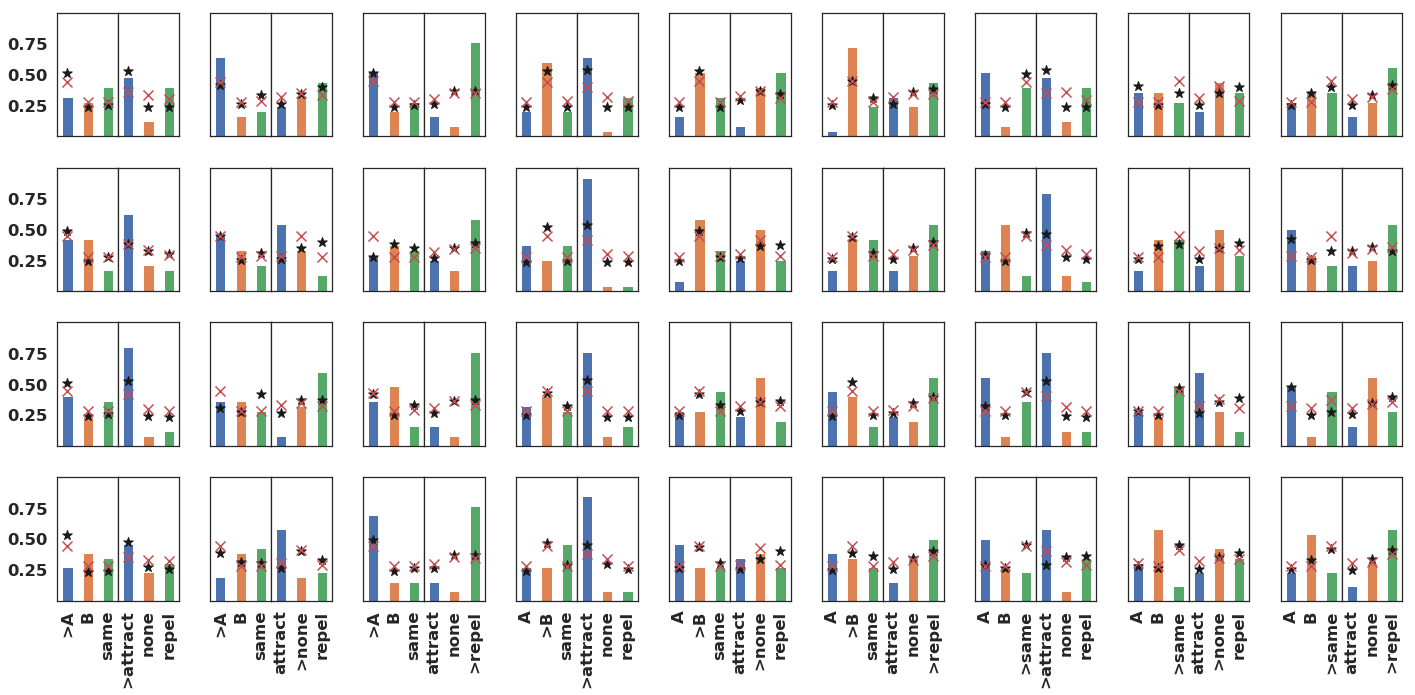

In [28]:
nrows = 4
ncols = 9
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(nrows, ncols, wspace=0.05, hspace=0.05)

for i in range(36):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.0, hspace=0.1)

    ax1 = plt.Subplot(fig, inner[0])
    passive_responses[["A_human_per", "B_human_per", "same_human_per"]].iloc[i].plot(kind="bar", ax=ax1)
    xticks = ax1.get_xticks()
    ax1.scatter(xticks, regressed_mass_with_rnn[i], zorder=10, c="k", marker="*", s=100)
    ax1.scatter(xticks, regressed_mass_with_io[i], zorder=10, c="r", marker="x", s=100)
    ax1.set_ylim(0, 1)
    
    ax2 = plt.Subplot(fig, inner[1])
    passive_responses[["attract_human_per", "none_human_per", "repel_human_per"]].iloc[i].plot(kind="bar", ax=ax2)
    xticks = ax2.get_xticks()
    ax2.scatter(xticks, regressed_force_with_rnn[i], zorder=10, c="k", marker="*", s=100)
    ax2.scatter(xticks, regressed_force_with_io[i], zorder=10, c="r", marker="x", s=100)
    ax2.set_ylim(0, 1)
    
    row = i // ncols
    if row != (nrows - 1):
        ax1.set_xticks([])
        ax2.set_xticks([])
    else:
        mass_labels = []
        for label in MASS_CLASS_COLS:
            if label == passive_responses.iloc[i].true_mass:
                label = ">" + label
            mass_labels.append(label)
        ax1.set_xticklabels(mass_labels)

        rel_labels = []
        for label in FORCE_CLASS_COLS:
            if label == passive_responses.iloc[i].true_rel:
                label = ">" + label
            rel_labels.append(label)
        ax2.set_xticklabels(rel_labels)

    ax2.set_yticks([])
    col = i % ncols
    if col != 0:
        ax1.set_yticks([])
    else:
        ax1.set_yticks([0.25, 0.5, 0.75])
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

# fig.show()
outer.tight_layout(fig)
plt.savefig("/home/hector/Downloads/index.pdf")

# Correlation between human accuracy and average RNN softmax

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

sns.set(font_scale=2)
sns.set_style("white")

In [30]:
def plot_correlation_between_accuracy_and_average_softmax(true_class, model_suffix):    
    human_accuracy = []
    model_values = []
    for i, cl in enumerate(passive_responses[true_class]):
        human_accuracy.append(passive_responses[cl+"_human_per"].iloc[i])
        model_values.append(passive_responses[cl+model_suffix].iloc[i])
    
    df = pd.DataFrame({"Human accuracy": human_accuracy, "Avg Softmax Value": model_values})
    plt.figure(figsize=(8, 6))
    sns.regplot(x="Avg Softmax Value", y="Human accuracy", data=df, scatter_kws={"s": 100})
    
    
    corr_coef, pval = spearmanr(human_accuracy, model_values)
    plt.title("$r_s$ = %.3f" % corr_coef, weight="bold", size=30)
    sns.despine()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


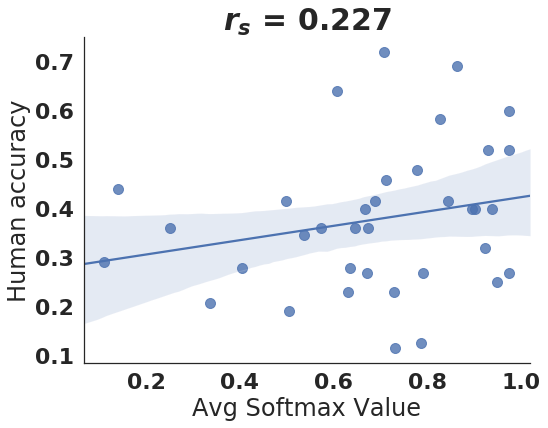

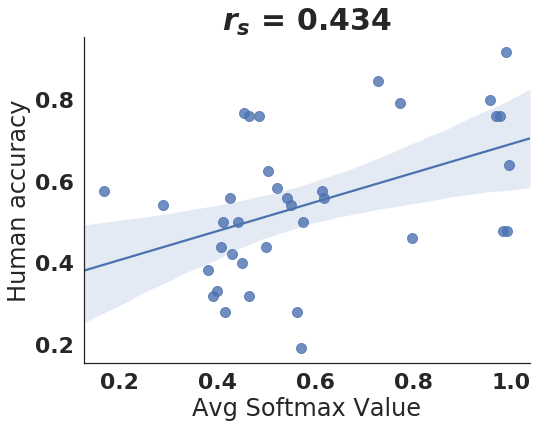

In [31]:
plot_correlation_between_accuracy_and_average_softmax("true_mass", "_rnn")
plot_correlation_between_accuracy_and_average_softmax("true_rel", "_rnn")

# Correlation between human per class percentages and RNN class softmax

In [32]:
sns.set_style("white")

In [33]:
def plot_correlation():
    
    nrows = 2
    ncols = 3
    fig = plt.figure(figsize=(20, 10))
    outer = gridspec.GridSpec(nrows, ncols, wspace=0.1, hspace=0.2)
    
    for i, cl in enumerate(MASS_CLASS_COLS + FORCE_CLASS_COLS):
        inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)

        col = i % ncols
        row = i // ncols
        if row == 0:
            true_class = "true_mass"
        else:
            true_class = "true_rel"
            
        ax = plt.Subplot(fig, outer[i])
        ax.set_title(cl, pad=25)
        ax.axis('off')
        fig.add_subplot(ax)
        
        for j, model_suffix in enumerate(["_rnn", "_io"]):
            ax = plt.Subplot(fig, inner[j])

            is_example_correct = (passive_responses[true_class] == cl)
            class_examples = passive_responses[is_example_correct]
            ax.scatter(class_examples[cl+model_suffix], class_examples[cl+"_human_per"], marker="o",
                         label=cl+" example")
            ax.set_xlim(-0.05, 1.05)
        
            other_examples = passive_responses[~is_example_correct]
            ax.scatter(other_examples[cl+model_suffix], other_examples[cl+"_human_per"], marker="x",
                         label=cl+" example")
            ax.set_ylim(-0.05, 1.05)
            
            corr_coef, pval = spearmanr(passive_responses[cl+model_suffix], passive_responses[cl+"_human_per"])
            ax.set_title("ρ=%.3f" % corr_coef)
            
            if row == 0:
                ax.set_xticklabels([])
            if col != 0 or j == 1:
                ax.set_yticklabels([])
            ax.grid()
            fig.add_subplot(ax)

    plt.tight_layout()
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_softmax_correlation.pdf")
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_softmax_correlation.jpg")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


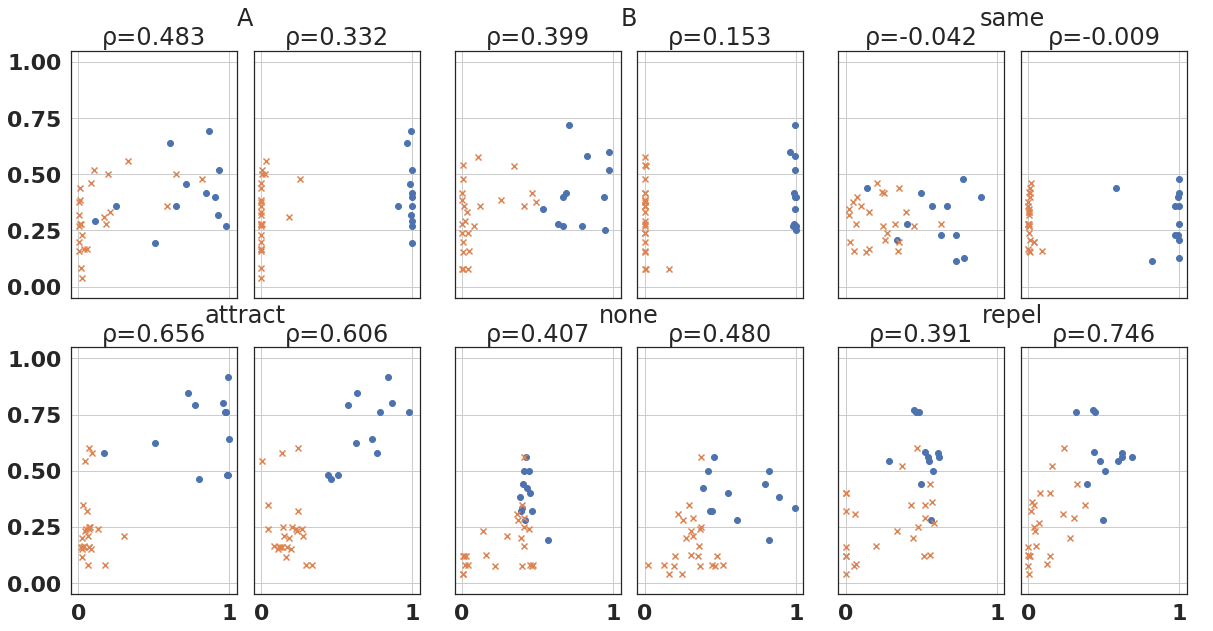

In [34]:
plot_correlation()

# Correlation between certainty and participant confidence

In [35]:
sns.set(font_scale=2)
sns.set_style("white")

In [36]:
def entropy_response_rnn(responses):
    return -np.sum(responses * np.log2(responses), axis=1)

max_entropy = entropy_response_rnn(np.array([[1/3, 1/3, 1/3]]))

In [37]:
model_class_columns = [cl + "_rnn" for cl in MASS_CLASS_COLS]
passive_responses["rnn_mass_certainty"] = max_entropy - entropy_response_rnn(passive_responses[model_class_columns])
passive_responses["io_mass_certainty"] = max_entropy - passive_responses["post_ent_mass.rtheta"]

model_class_columns = [cl + "_rnn" for cl in FORCE_CLASS_COLS]
passive_responses["rnn_force_certainty"] = max_entropy - entropy_response_rnn(passive_responses[model_class_columns])
passive_responses["io_force_certainty"] = max_entropy - passive_responses["post_ent_rel.rtheta"]

In [38]:
def plot_entropy_correlation(xcol, ycol, xlabel, ylabel):
    corr, pval = spearmanr(passive_responses[xcol], passive_responses[ycol])
    plt.figure(figsize=(8, 6))
    sns.regplot(x=xcol, y=ycol, data=passive_responses, scatter_kws={"s": 100})
    plt.title("$r_s$ = %.3f" % corr, weight="bold", size=30)
    
    plt.ylabel(ylabel, weight="bold")
    plt.xlabel(xlabel, weight="bold")
    sns.despine()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


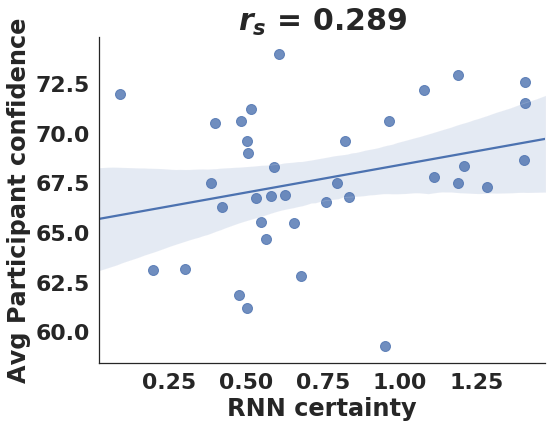

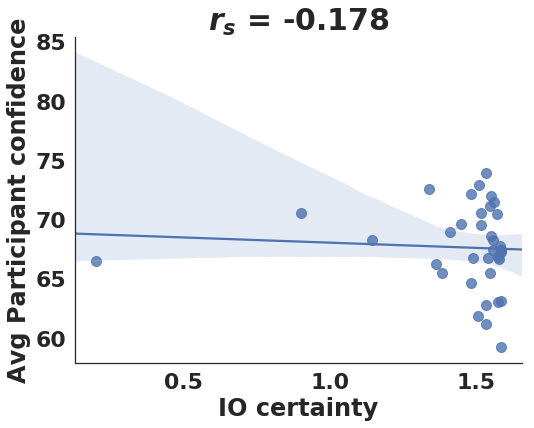

In [40]:
plot_entropy_correlation("rnn_mass_certainty", "conf_mass", "RNN certainty", "Avg Participant confidence")
plt.savefig("cogsci_images/mass_rnn_certainty_vs_participant_confidence.pdf")
plt.savefig("cogsci_images/mass_rnn_certainty_vs_participant_confidence.jpg")

plot_entropy_correlation("io_mass_certainty", "conf_mass", "IO certainty", "Avg Participant confidence")
plt.savefig("cogsci_images/mass_io_certainty_vs_participant_confidence.pdf")
plt.savefig("cogsci_images/mass_io_certainty_vs_participant_confidence.jpg")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


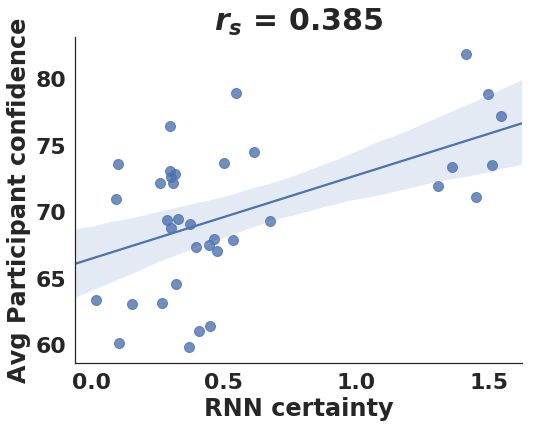

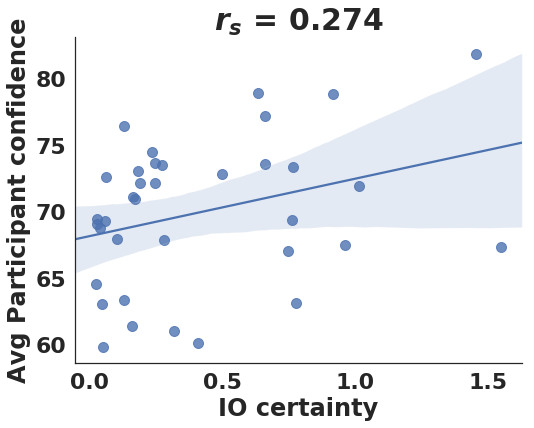

In [39]:
plot_entropy_correlation("rnn_force_certainty", "conf_rel", "RNN certainty", "Avg Participant confidence")
plt.savefig("cogsci_images/force_rnn_certainty_vs_participant_confidence.pdf")
plt.savefig("cogsci_images/force_rnn_certainty_vs_participant_confidence.jpg")

plot_entropy_correlation("io_force_certainty", "conf_rel", "IO certainty", "Avg Participant confidence")
plt.savefig("cogsci_images/force_io_certainty_vs_participant_confidence.pdf")
plt.savefig("cogsci_images/force_io_certainty_vs_participant_confidence.jpg")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


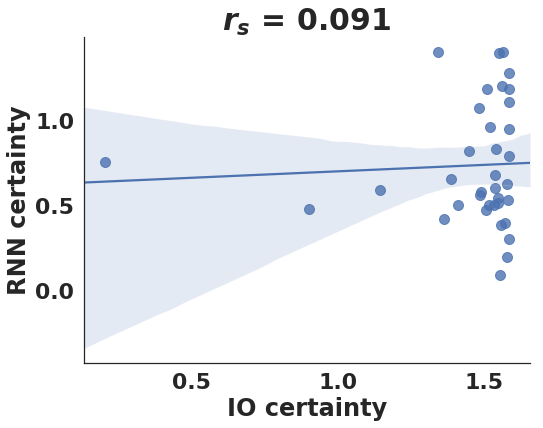

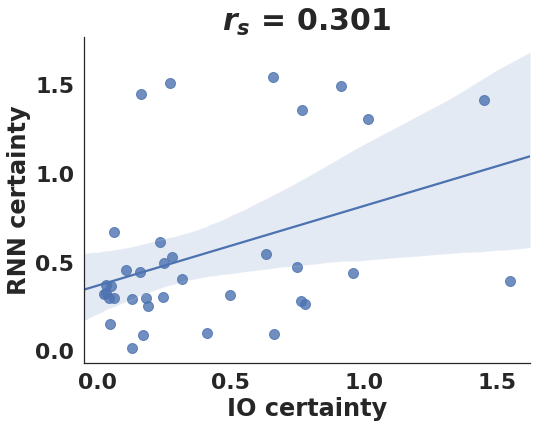

In [41]:
plot_entropy_correlation("io_mass_certainty", "rnn_mass_certainty", "IO certainty", "RNN certainty")
plt.savefig("cogsci_images/mass_io_certainty_vs_rnn_certainty.pdf")
plt.savefig("cogsci_images/mass_io_certainty_vs_rnn_certainty.jpg")

plot_entropy_correlation("io_force_certainty", "rnn_force_certainty", "IO certainty", "RNN certainty")
plt.savefig("cogsci_images/force_io_certainty_vs_rnn_certainty.pdf")
plt.savefig("cogsci_images/force_io_certainty_vs_rnn_certainty.jpg")